# 主成分分析

相当于无监督评估器的一种，可以从无标签的数据中挖掘出有趣的信息。

PCA 是一种非常基础的降维算法，经常被用于：  
* 数据可视化
* 噪音过滤
* 特征抽取
* 特征工程

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 主成分分析简介

(-2.7378957575985226,
 2.5788989913065881,
 -0.94549527304399739,
 1.0172909457553052)

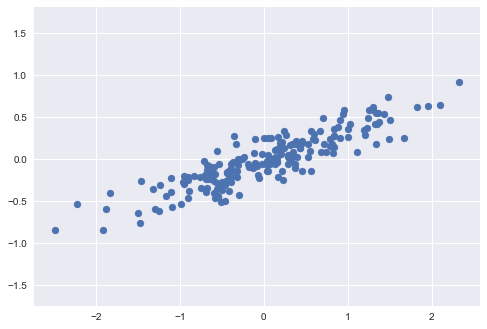

In [15]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:,0], X[:,1])
plt.axis('equal')

第一维特征和第二维具有明显的相关性，注意这里和前面不同，y不是最终要求的变量，x y 都是自变量   
主成分分析的思路是找到一个正交坐标系，使得所有样本点在坐标轴上的投影具有最大可分性，基本做法是对协方差矩阵做特征值分解，依据降维的需要逐层选择特征值和相应的特征向量作为坐标轴。   
如果PCA 成功，说明在去掉一些比较难分的信息以后，样本能够用于分类或回归的信息占比更大了，更容易凸显，这些信息刚好在整个数据保证样本最大可分时的前几个特征向量中，如果 PCA 效果不好，说明在降维的过程中，损失了一部分比较重要的信息  

### 仿射变换

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
# 成分，就是特征值向量
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [18]:
# 可解释差异 类似特征值
print(pca.explained_variance_)

[ 0.7625315  0.0184779]


In [19]:
def draw_vector(v0, v1, ax = None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle='->',
                     linewidth = 2,
                     shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

(-2.7378957575985226,
 2.5788989913065881,
 -0.94549527304399739,
 1.0172909457553052)

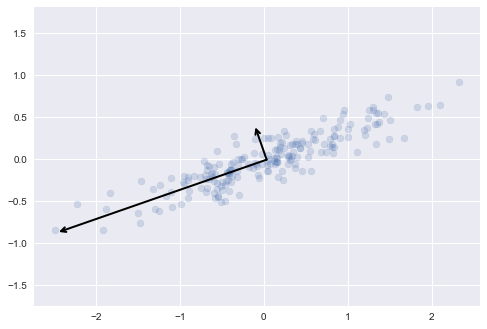

In [20]:
# 画出数据

plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal')

长的就是主轴，相应的主成分   
这种变换称为仿射变换，包含平移，旋转和均匀缩放 （线性变化）  
所谓的降维，就是把最不重要的轴一个个舍去

### 降维

In [21]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape: ", X.shape)
print("transformed shape: ", X_pca.shape)

original shape:  (200, 2)
transformed shape:  (200, 1)


(-2.7649537820213026,
 2.6551825979217609,
 -0.99198805419665281,
 1.0195048877149555)

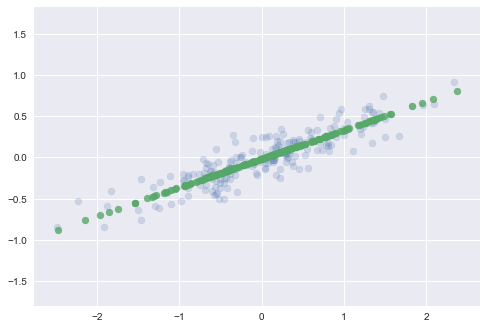

In [27]:
X_new = pca.inverse_transform(X_pca) # 逆变换，把一维的数据，转换到原来二维
plt.scatter(X[:, 0], X[:, 1], alpha = 0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha = 0.8)
plt.axis('equal')

### 可视化手写数字

In [29]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [30]:
pca = PCA(2)
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)
